# Setup
Die folgenden Code-Blöcke können genutzt werden, um die benötigten Abhängigkeiten zu installieren und zu importieren.

In [57]:
%%capture
%pip install -r ../requirements.txt

In [58]:
%%capture
%load_ext pretty_jupyter

In [59]:
%%capture
# Laden der eingesetzten Libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from itables import init_notebook_mode
from datetime import datetime
from IPython.display import display
import sweetviz as sv

init_notebook_mode(all_interactive=True)

# Aufgabenstellung
Inhalt der hier bearbeiteten und dokumentierten Mini-Challenge für das Modul «aml - Angewandtes Machine Learning» der FHNW ist die Entwicklung und Evaluierung von Aﬀinitätsmodellen für personalisierte Kreditkarten-Werbekampagnen im Auftrag einer Bank. Das Ziel der Authoren ist es also, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs einer bestimmten Person vorhersagen.

In [60]:
%%capture
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from itables import init_notebook_mode
from datetime import datetime
from IPython.display import display
import sweetviz as sv

init_notebook_mode(all_interactive=True)

# Laden der zur Verfügung gestellten Daten
[//]: # (-.- .tabset)

Zur Verfügung gestellt wurden 8 csv-Dateien von welchen die Beschreibung der erfassten Variablen unter dem folgenden Link eingesehen werden können: [PKDD'99 Discovery Challenge - Guide to the Financial Data Set](https://sorry.vse.cz/~berka/challenge/PAST/index.html). Nachfolgend werden diese csv-Dateien eingelesen.

In [61]:
account = pd.read_csv("./data/account.csv", sep=";", dtype={"date": "str"})
card = pd.read_csv("./data/card.csv", sep=";", dtype={"issued": "str"})
client = pd.read_csv("./data/client.csv", sep=";")
disp = pd.read_csv("./data/disp.csv", sep=";")
district = pd.read_csv("./data/district.csv", sep=";")
loan = pd.read_csv("./data/loan.csv", sep=";", dtype={"date": "str"})
order = pd.read_csv("./data/order.csv", sep=";")
trans = pd.read_csv("./data/trans.csv", sep=";", dtype={"date": "str", "bank": "str"})

## account.csv
Der Datensatz `accounts.csv` beinhaltet die folgenden Informationen über die Kontos der Bank:  
- `account_id`: die Kontonummer, 
- `district_id`: den Standort der entsprechenden Bankfiliale,
- `issuance_statement_frequency`: die Frequenz der Ausstellung von Kontoauszügen (monatlich, wöchentlich, pro Transaktion) und 
- `date`: das Erstellungsdatum

In [62]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


## card.csv
Der Datensatz `card.csv` beinhaltet die folgenden Informationen über die von der Bank herausgegebenen Kreditkarten:  
- `card_id`: die Kartennummer, 
- `disp_id`: die Zuordnung zum entsprechenden Bankkonto und -inhaber (Disposition),
- `type`: die Art der Kreditkarte (junior, classic, gold) und 
- `issued`: das Ausstellungsdatum

In [63]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


## client.csv
Der Datensatz `client.csv` beinhaltet die folgenden Informationen über die Kunden der Bank:  
- `client_id`: die Kundennummer, 
- `birth_number`: eine Kombination aus Geburtsdatum und Geschlecht sowie
- `district_id`: die Adresse  

In [64]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


## disp.csv
Der Datensatz `disp.csv` beinhaltet die folgenden Informationen über die Dispositionen der Bank:  
- `disp_id`: der Identifikationsschlüssel der Disposition,
- `client_id`: die Kundennummer,
- `account_id`: die Kontonummer,
- `type`: die Art der Disposition (Inhaber, Benutzer)

In [65]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


## district.csv
Der Datensatz `district.csv` beinhaltet die folgenden demografischen Informationen:  
- `A1`: die ID des Distrikts, 
- `A2`: der Name des Distrikts,
- `A3`: die Region,
- `A4`: die Anzahl der Einwohner,
- `A5`: die Anzahl der Gemeinden mit < 499 Einwohner,
- `A6`: die Anzahl der Gemeinden mit 500 - 1999 Einwohner,
- `A7`: die Anzahl der Gemeinden mit 2000 - 9999 Einwohner,
- `A8`: die Anzahl der Gemeinden mit >10000 Einwohner,
- `A9`: die Anzahl Städte,
- `A10`: das Verhältnis von städtischen Einwohnern,
- `A11`: das durchschnittliche Einkommen,
- `A12`: die Arbeitslosenrate vom Jahr 95,
- `A13`: die Arbeitslosenrate vom Jahr 96,
- `A14`: die Anzahl von Unternehmer pro 1000 Einwohner,
- `A15`: die Anzahl von begangenen Verbrechen im Jahr 95,
- `A16`: die Anzahl von begangenen Verbrechen im Jahr 96,

In [66]:
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


## loan.csv
Der Datensatz `loan.csv` beinhaltet die folgenden Informationen über die vergebenen Darlehen der Bank:  
- `loan_id`: ID des Darlehens,
- `account_id`: die Kontonummer,
- `date`: das Datum, wann das Darlehen gewährt wurde,
- `amount`: der Betrag,
- `duration`: die Dauer des Darlehens,
- `payments`: die höhe der monatlichen Zahlungen und
- `status`: der Rückzahlungsstatus (A: ausgeglichen, B: Vertrag abgelaufen aber nicht fertig bezahlt, C: laufender Vertrag und alles in Ordnung, D: laufender Vertrag und Kunde verschuldet)

In [67]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    object 
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 37.4+ KB


## order.csv
Der Datensatz `order.csv` beinhaltet die folgenden Informationen über die Daueraufträge eines Kontos:  
- `order_id`: die Nummer des Dauerauftrags,
- `account_id`: die Kontonummer von welchem der Auftrag stammt,
- `bank_to`: die empfangende Bank,
- `account_to`: das empfangende Konto, 
- `amount`: der Betrag,
- `k_symbol`: die Art des Auftrags (Versicherungszahlung, Haushalt, Leasing, Darlehen)

In [68]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


## trans.csv
Der Datensatz `trans.csv` beinhaltet die folgenden Informationen über die Transaktionen eines Kontos:  
- `trans_id`: die ID der Transaktion,
- `account_id`: die Kontonummer des ausführenden Kontos,
- `date`: das Datum,
- `type`: der Typ (Einzahlung, Bezug)
- `operation`: die Art der Transaktion (Bezug Kreditkarte, Bareinzahlung, Bezug über eine andere Bank, Bezug Bar, Überweisung)
- `amount`: der Betrag der Transaktion,
- `balance`: der Kontostand nach ausführung der Transaktion,
- `k_symbol`: die Klassifikation der Transaktion (Versicherungszahlung, Kontoauszug, Zinsauszahlung, Zinszahlung bei negativem Kontostand, Haushalt, Pension, Darlehensauszahlung),
- `bank`: die empfangende Bank und 
- `account`: das empfangende Bankkonto

In [69]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  object 
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 80.6+ MB


# Transformationen 
[//]: # (-.- .tabset)

Im folgenden Abschnitt werden die geladenen Daten separat so transformiert, dass jede Zeile einer Observation und jede Spalte einer Variable im entsprechenden Datenformat entspricht, also ins Tidy-Format gebracht.

In [70]:
data_frames = {}

## Account

In [71]:
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")
# Frequency Transformation
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly issuance",
        "POPLATEK TYDNE": "weekly issuance",
        "POPLATEK PO OBRATU": "issuance after transaction",
    }
)

# Rename Column
account = account.rename(columns={"frequency": "issuance_statement_frequency"})

# Convert Date Column to datetime format
account["date"] = pd.to_datetime(account["date"])

# Assuming 'data_frames' is a dictionary of DataFrames
data_frames["account.csv"] = account

# Sample 5 random rows
account.sample(n=5)

account_id  district_id issuance_statement_frequency       date
3491         599           54             monthly issuance 1996-12-04
3175        2045           34             monthly issuance 1996-09-09
371        10105           55             monthly issuance 1993-04-28
1434        1766           28             monthly issuance 1994-09-03
1112        3292            1             monthly issuance 1993-12-21

In [72]:
%%capture
svReport_account = sv.analyze(account)
svReport_account.show_html(filepath = "./reports/accounts.html", open_browser = False)

## Card

In [73]:
# Man kann die Zeit weglassen da immer 00:00:00
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")
card["issued"] = pd.to_datetime(card["issued"], format="mixed")
data_frames["card.csv"] = card

In [74]:
%%capture
svReport_card = sv.analyze(card)
svReport_card.show_html(filepath = "./reports/card.html", open_browser = False)

## Client

In [75]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
        base_date.year
        - birth_date.year
        - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Anwenden der Funktionen und Erstellen neuer Spalten
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["age"] = client["birth_day"].apply(calculate_age)

data_frames["client.csv"] = client

# Auswahl spezifischer Spalten für die finale DataFrame (optional, je nach Bedarf)
# Sample 5 random rows
client.sample(n=5)

client_id  birth_number  district_id  gender  birth_day  age
1180       1241        426217           73  female 1942-12-17   57
101         108        630913           17    male 1963-09-13   36
629         661        195115           16  female 1919-01-15   80
2755       2911        320925           45    male 1932-09-25   67
453         477        540720            1    male 1954-07-20   45

In [76]:
%%capture
svReport_client = sv.analyze(client)
svReport_client.show_html(filepath = "./reports/client.html", open_browser = False)

## Disp

In [77]:
data_frames["disp.csv"] = disp

# random sample
disp.sample(n=5)

disp_id  client_id  account_id   type
1866     1977       1977        1631  OWNER
3053     3222       3222        2668  OWNER
3720     3930       3930        3250  OWNER
1310     1380       1380        1147  OWNER
366       387        387         317  OWNER

In [78]:
%%capture
svReport_disp = sv.analyze(disp)
svReport_disp.show_html(filepath = "./reports/disp.html", open_browser = False)

## District


- A1 district_id/district code
- A2 district name
- A3 region
- A4 no. of inhabitants
- A5 no. of municipalities with inhabitants < 499
- A6 no. of municipalities with inhabitants 500-1999 A7 no. of municipalities with inhabitants 2000-9999
- A8 no. of municipalities with inhabitants >10000
- A9 no. of cities
- A10 ratio of urban inhabitants
- A11 average salary
- A12 unemploymant rate ’95
- A13 unemploymant rate ’96
- A14 no. of enterpreneurs per 1000 inhabitants
- A15 no. of commited crimes ’95
- A16 no. of commited crimes ’96

In [79]:
import pandas as pd
# Renaming and selecting columns
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

data_frames["district.csv"] = district

district.sample(n=5)
district

district_id    district_name           region  num_of_habitat  \
0             1      Hl.m. Praha           Prague         1204953   
1             2          Benesov  central Bohemia           88884   
2             3           Beroun  central Bohemia           75232   
3             4           Kladno  central Bohemia          149893   
4             5            Kolin  central Bohemia           95616   
..          ...              ...              ...             ...   
72           73            Opava    north Moravia          182027   
73           74  Ostrava - mesto    north Moravia          323870   
74           75           Prerov    north Moravia          138032   
75           76          Sumperk    north Moravia          127369   
76           77           Vsetin    north Moravia          148545   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
0                   0                   0                0   
1                  80                  26                6   
2                  55                  26                4   
3                  63                  29                6   
4                  65                  30                4   
..                ...                 ...              ...   
72                 17                  49               12   
73                  0                   0                0   
74                 67                  30                4   
75                 31                  32               13   
76                  8                  35               12   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
0                    1            1           100.0           12541   
1                    2            5            46.7            8507   
2                    1            5            41.7            8980   
3                    2            6            67.4            9753   
4                    1            6            51.4            9307   
..                 ...          ...             ...             ...   
72                   2            7            56.4            8746   
73                   1            1           100.0           10673   
74                   2            5            64.6            8819   
75                   2            7            51.2            8369   
76                   3            4            53.5            8909   

   unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
0             0.29             0.43                             167   
1             1.67             1.85                             132   
2             1.95             2.21                             111   
3             4.64             5.05                             109   
4             3.85             4.43                             118   
..             ...              ...                             ...   
72            3.33             3.74                              90   
73            4.75             5.44                             100   
74            5.38             5.66                              99   
75            4.73             5.88                             107   
76            4.01             5.56                             113   

   no_of_crimes95  no_of_crimes96  
0           85677           99107  
1            2159            2674  
2            2824            2813  
3            5244            5892  
4            2616            3040  
..            ...             ...  
72           4355            4433  
73          18782           18347  
74           4063            4505  
75           3736            2807  
76           3460            3590  

[77 rows x 16 columns]

In [80]:
# find the ? in the district dataframe
district[district.isin(["?"]).any(axis=1)]

district_id district_name         region  num_of_habitat  \
68           69       Jesenik  north Moravia           42821   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
68                  4                  13                5   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
68                   1            3            48.4            8173   

   unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
68               ?             7.01                             124   

   no_of_crimes95  no_of_crimes96  
68              ?            1358

In [81]:
# replace the ? with NaN
district = district.replace("?", np.nan)

# replace the NaN with the mean of the column no_of_crimes95 and unemploy_rate95
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)
district["no_of_crimes95"] = district["no_of_crimes95"].fillna(
    district["no_of_crimes95"].mean()
)
district["unemploy_rate95"] = district["unemploy_rate95"].fillna(
    district["unemploy_rate95"].mean()
)
# check if there are still NaN values in no_of_crimes95 and unemploy_rate95
district[district.isin([np.nan]).any(axis=1)]

Empty DataFrame
Columns: [district_id, district_name, region, num_of_habitat, num_of_small_town, num_of_medium_town, num_of_big_town, num_of_bigger_town, num_of_city, ratio_of_urban, average_salary, unemploy_rate95, unemploy_rate96, n_of_enterpren_per1000_inhabit, no_of_crimes95, no_of_crimes96]
Index: []

In [82]:
%%capture
svReport_district = sv.analyze(district)
svReport_district.show_html(filepath = "./reports/district.html", open_browser = False)

## Loan

In [83]:
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")
# Convert the 'date' column to datetime format
loan["date"] = pd.to_datetime(loan["date"], format="mixed")

# Mutate the 'status' column based on conditions
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

# Group by 'account_id', calculate the number of loans, and sort the results
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

# Display the resulting DataFrame
num_of_loan_df

account_id  num_of_loan
0             2            1
457        7890            1
449        7795            1
450        7815            1
451        7819            1
..          ...          ...
229        4079            1
230        4081            1
231        4099            1
232        4116            1
681       11362            1

[682 rows x 2 columns]

In [84]:
# Perform an inner join between 'loan' and 'num_of_loan_df' on 'account_id'
loan = pd.merge(loan, num_of_loan_df, on="account_id", how="inner")

# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

# Sample 5 random rows from the joined DataFrame
loan.sample(n=100)

loan_id  account_id       date  amount  duration  payments  \
320     5591        3021 1996-12-04  155616        48    3242.0   
73      6004        4937 1994-07-23  143904        24    5996.0   
28      6650        8073 1994-02-17   49320        12    4110.0   
31      7262       11135 1994-03-01  182628        36    5073.0   
424     5041         319 1997-07-11  369000        60    6150.0   
..       ...         ...        ...     ...       ...       ...   
85      6686        8260 1994-08-25  224604        36    6239.0   
384     5634        3229 1997-05-01   39024        12    3252.0   
555     6730        8523 1998-02-15   93036        12    7753.0   
103     5390        2167 1994-10-30  170256        24    7094.0   
263     6992        9790 1996-07-27  133968        48    2791.0   

                               status  num_of_loan  
320                  running contract            1  
73                  contract finished            1  
28   finished contract, loan not paid            1  
31                  contract finished            1  
424                  running contract            1  
..                                ...          ...  
85                  contract finished            1  
384                 contract finished            1  
555                  running contract            1  
103                 contract finished            1  
263                  running contract            1  

[100 rows x 8 columns]

In [85]:
%%capture
svReport_loan = sv.analyze(loan)
svReport_loan.show_html(filepath = "./reports/loan.html", open_browser = False)

## Order


In [86]:
order

order_id  account_id bank_to  account_to  amount  k_symbol
0        29401           1      YZ    87144583  2452.0      SIPO
1        29402           2      ST    89597016  3372.7      UVER
2        29403           2      QR    13943797  7266.0      SIPO
3        29404           3      WX    83084338  1135.0      SIPO
4        29405           3      CD    24485939   327.0          
...        ...         ...     ...         ...     ...       ...
6466     46334       11362      YZ    70641225  4780.0      SIPO
6467     46335       11362      MN    78507822    56.0          
6468     46336       11362      ST    40799850   330.0  POJISTNE
6469     46337       11362      KL    20009470   129.0          
6470     46338       11362      MN    61540514  5392.0      UVER

[6471 rows x 6 columns]

In [87]:
# Assuming 'order' and 'account' DataFrames are already loaded

# Correctly map and fill missing values in 'k_symbol' column
order["k_symbol"] = (
    order["k_symbol"]
    .map(
        {
            "POJISTNE": "insurance_payment",
            "SIPO": "household",
            "UVER": "loan_payment",
            "LEASING": "leasing",
        }
    )
    .fillna("unknown")
)

# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("unknown")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

orders_pivot = order.pivot_table(
    index="account_id", columns="k_symbol", values="amount", aggfunc="sum"
)

# Add prefix to column names
orders_pivot.columns = orders_pivot.columns


orders_pivot = orders_pivot.reset_index()
# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = orders_pivot

# NaN to 0
data_frames["order.csv"] = data_frames["order.csv"].fillna(0)
# Sample 5 random rows from the merged DataFrame
data_frames["order.csv"].sample(n=10)

k_symbol  account_id  household  insurance_payment  leasing  loan_payment  \
2654            2791     3215.0                0.0      0.0           0.0   
1782            1874     2100.0                0.0      0.0           0.0   
2507            2634        0.0                0.0      0.0           0.0   
2994            3148     2478.0                0.0      0.0           0.0   
325              342     2332.0                0.0      0.0           0.0   
3636            3827        0.0                0.0      0.0           0.0   
4082            5817     3105.0                0.0   3849.0           0.0   
2536            2664     3453.0                0.0      0.0           0.0   
3022            3179     2556.0                0.0      0.0           0.0   
3106            3267     6403.0                0.0      0.0           0.0   

k_symbol  unknown  
2654          0.0  
1782          0.0  
2507          0.0  
2994          0.0  
325           0.0  
3636          0.0  
4082       9352.0  
2536        475.0  
3022       1015.0  
3106          0.0

In [88]:
data_frames["order.csv"].columns

Index(['account_id', 'household', 'insurance_payment', 'leasing',
       'loan_payment', 'unknown'],
      dtype='object', name='k_symbol')

In [89]:
%%capture
svReport_order = sv.analyze(order)
svReport_order.show_html(filepath = "./reports/order.html", open_browser = False)

## Trans


In [90]:
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")
# Convert 'date' from string to datetime
trans["date"] = pd.to_datetime(trans["date"])

# Update 'type' column
trans["type"] = trans["type"].replace({"PRIJEM": "credit", "VYDAJ": "withdrawal"})

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)

# negate the amount if type is credit
trans.loc[trans['type'] == 'credit', 'amount'] = trans.loc[trans['type'] == 'credit', 'amount'] * (-1)

# Assign to a dictionary if needed (similar to list assignment in R)

data_frames["trans.csv"] = trans

# Sample 5 random rows from the DataFrame
trans.sample(n=1000)
trans

trans_id  account_id       date    type       operation  amount  \
0          695247        2378 1993-01-01  credit  credit in cash  -700.0   
1          171812         576 1993-01-01  credit  credit in cash  -900.0   
2          207264         704 1993-01-01  credit  credit in cash -1000.0   
3         1117247        3818 1993-01-01  credit  credit in cash  -600.0   
4          579373        1972 1993-01-02  credit  credit in cash  -400.0   
...           ...         ...        ...     ...             ...     ...   
1056315   3626622        2906 1998-12-31  credit             NaN   -62.3   
1056316   3627616        2935 1998-12-31  credit             NaN   -81.3   
1056317   3625403        2869 1998-12-31  credit             NaN   -60.2   
1056318   3626683        2907 1998-12-31  credit             NaN  -107.5   
1056319   3626540        2902 1998-12-31  credit             NaN  -164.1   

         balance           k_symbol bank  account  
0          700.0                NaN  NaN      NaN  
1          900.0                NaN  NaN      NaN  
2         1000.0                NaN  NaN      NaN  
3          600.0                NaN  NaN      NaN  
4          400.0                NaN  NaN      NaN  
...          ...                ...  ...      ...  
1056315  13729.4  interest credited  NaN      NaN  
1056316  19544.9  interest credited  NaN      NaN  
1056317  14638.2  interest credited  NaN      NaN  
1056318  23453.0  interest credited  NaN      NaN  
1056319  41642.9  interest credited  NaN      NaN  

[1056320 rows x 10 columns]

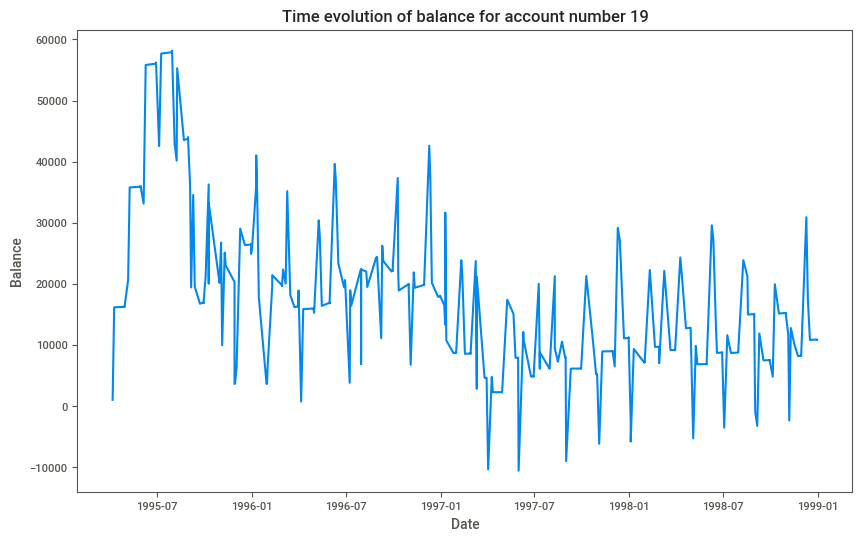

In [91]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

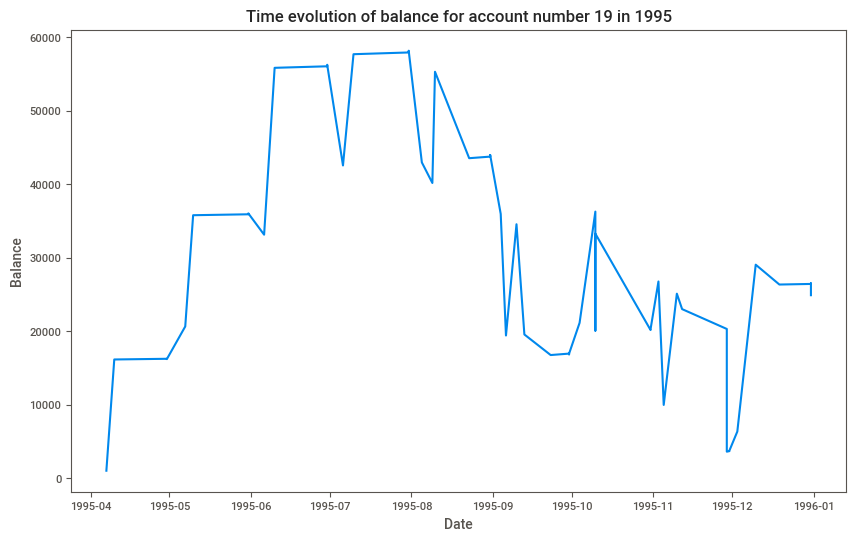

In [92]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

# Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

In [93]:
%%capture
svReport_trans = sv.analyze(trans)
svReport_trans.show_html(filepath = "./reports/trans.html", open_browser = False)

# Explorative Datenanalyse
In diesem Abschnitt wird mittels EDA ein Überblick über die eingelesenen Daten gewonnen.

# D&Q

In [94]:
# Check for missing values in each DataFrame
for df_name, df in data_frames.items():
    print(f"Missing values in {df_name}:")
    print(df.isna().sum().sum())  # Sum of all missing values in the DataFrame

Missing values in account.csv:
0
Missing values in card.csv:
0
Missing values in client.csv:
0
Missing values in disp.csv:
0
Missing values in district.csv:
0
Missing values in loan.csv:
0
Missing values in order.csv:
0
Missing values in trans.csv:
2208738


# Merge the Dataframe['XXX'] for non transaction Data

In [95]:
# merge dataframes
non_transactional_data = (
    data_frames["disp.csv"]
    .add_suffix("_disp")
    .merge(
        data_frames["account.csv"].add_suffix("_account"),
        left_on="account_id_disp",
        right_on="account_id_account",
        how="left",
    )
    .merge(
        data_frames["card.csv"].add_suffix("_card"),
        left_on="disp_id_disp",
        right_on="disp_id_card",
        how="left",
    )
    .merge(
        data_frames["loan.csv"].add_suffix("_loan"),
        left_on="account_id_disp",
        right_on="account_id_loan",
        how="left",
    )
    .merge(
        data_frames["order.csv"].add_suffix("_order"),
        left_on="account_id_disp",
        right_on="account_id_order",
        how="left",
    )
)

In [96]:
non_transactional_data.columns

Index(['disp_id_disp', 'client_id_disp', 'account_id_disp', 'type_disp',
       'account_id_account', 'district_id_account',
       'issuance_statement_frequency_account', 'date_account', 'card_id_card',
       'disp_id_card', 'type_card', 'issued_card', 'loan_id_loan',
       'account_id_loan', 'date_loan', 'amount_loan', 'duration_loan',
       'payments_loan', 'status_loan', 'num_of_loan_loan', 'account_id_order',
       'household_order', 'insurance_payment_order', 'leasing_order',
       'loan_payment_order', 'unknown_order'],
      dtype='object')

In [97]:
cols_to_replace_na = [
    "household_order",
    "insurance_payment_order",
    "loan_payment_order",
    "leasing_order",
    "unknown_order",
]

non_transactional_data[cols_to_replace_na] = non_transactional_data[
    cols_to_replace_na
].fillna(0)

## Dropping of Junior Cards that are not on the edge to a normal card Analyse


In [98]:
# join district and client left join on district_id
non_transactional_data = non_transactional_data.merge(
    data_frames["district.csv"],
    left_on="district_id_account",
    right_on="district_id",
    how="left",
)

non_transactional_data

disp_id_disp  client_id_disp  account_id_disp  type_disp  \
0                1               1                1      OWNER   
1                2               2                2      OWNER   
2                3               3                2  DISPONENT   
3                4               4                3      OWNER   
4                5               5                3  DISPONENT   
...            ...             ...              ...        ...   
5364         13647           13955            11349      OWNER   
5365         13648           13956            11349  DISPONENT   
5366         13660           13968            11359      OWNER   
5367         13663           13971            11362      OWNER   
5368         13690           13998            11382      OWNER   

      account_id_account  district_id_account  \
0                      1                   18   
1                      2                    1   
2                      2                    1   
3                      3                    5   
4                      3                    5   
...                  ...                  ...   
5364               11349                    1   
5365               11349                    1   
5366               11359                   61   
5367               11362                   67   
5368               11382                   74   

     issuance_statement_frequency_account date_account  card_id_card  \
0                        monthly issuance   1995-03-24           NaN   
1                        monthly issuance   1993-02-26           NaN   
2                        monthly issuance   1993-02-26           NaN   
3                        monthly issuance   1997-07-07           NaN   
4                        monthly issuance   1997-07-07           NaN   
...                                   ...          ...           ...   
5364                      weekly issuance   1995-05-26           NaN   
5365                      weekly issuance   1995-05-26           NaN   
5366                     monthly issuance   1994-10-01        1247.0   
5367                     monthly issuance   1995-10-14           NaN   
5368                     monthly issuance   1995-08-20           NaN   

      disp_id_card  ... num_of_big_town num_of_bigger_town  num_of_city  \
0              NaN  ...               2                  1            4   
1              NaN  ...               0                  1            1   
2              NaN  ...               0                  1            1   
3              NaN  ...               4                  1            6   
4              NaN  ...               4                  1            6   
...            ...  ...             ...                ...          ...   
5364           NaN  ...               0                  1            1   
5365           NaN  ...               0                  1            1   
5366       13660.0  ...               5                  1            6   
5367           NaN  ...               6                  2            6   
5368           NaN  ...               0                  1            1   

      ratio_of_urban average_salary  unemploy_rate95  unemploy_rate96  \
0               65.3           8968             2.83             3.35   
1              100.0          12541             0.29             0.43   
2              100.0          12541             0.29             0.43   
3               51.4           9307             3.85             4.43   
4               51.4           9307             3.85             4.43   
...              ...            ...              ...              ...   
5364           100.0          12541             0.29             0.43   
5365           100.0          12541             0.29             0.43   
5366            53.8           8814             4.76             5.74   
5367            63.1           8110             5.77             6.55   
5368           100.0          10673             4.75   

In [99]:
# merge client with suffix
non_transactional_data = non_transactional_data.merge(
    data_frames["client.csv"].add_suffix("_client"),
    left_on="client_id_disp",
    right_on="client_id_client",
    how="left",
)

In [100]:
non_transactional_data["has_card"] = ~non_transactional_data["card_id_card"].isna()

# Filter rows where 'has_card' is True
filtered_data = non_transactional_data[non_transactional_data["has_card"]]

# Check if there are duplicated 'account_id' in the filtered data
duplicated_account_id = filtered_data["account_id_account"].duplicated().sum()

print(duplicated_account_id)

0



## Junior Cards removal

disp_id_disp  client_id_disp  account_id_disp  type_disp  \
0                1               1                1      OWNER   
1                2               2                2      OWNER   
2                3               3                2  DISPONENT   
3                4               4                3      OWNER   
4                5               5                3  DISPONENT   
...            ...             ...              ...        ...   
5364         13647           13955            11349      OWNER   
5365         13648           13956            11349  DISPONENT   
5366         13660           13968            11359      OWNER   
5367         13663           13971            11362      OWNER   
5368         13690           13998            11382      OWNER   

      account_id_account  district_id_account  \
0                      1                   18   
1                      2                    1   
2                      2                    1   
3                      3                    5   
4                      3                    5   
...                  ...                  ...   
5364               11349                    1   
5365               11349                    1   
5366               11359                   61   
5367               11362                   67   
5368               11382                   74   

     issuance_statement_frequency_account date_account  card_id_card  \
0                        monthly issuance   1995-03-24           NaN   
1                        monthly issuance   1993-02-26           NaN   
2                        monthly issuance   1993-02-26           NaN   
3                        monthly issuance   1997-07-07           NaN   
4                        monthly issuance   1997-07-07           NaN   
...                                   ...          ...           ...   
5364                      weekly issuance   1995-05-26           NaN   
5365                      weekly issuance   1995-05-26           NaN   
5366                     monthly issuance   1994-10-01        1247.0   
5367                     monthly issuance   1995-10-14           NaN   
5368                     monthly issuance   1995-08-20           NaN   

      disp_id_card  ... n_of_enterpren_per1000_inhabit no_of_crimes95  \
0              NaN  ...                            131           1740   
1              NaN  ...                            167          85677   
2              NaN  ...                            167          85677   
3              NaN  ...                            118           2616   
4              NaN  ...                            118           2616   
...            ...  ...                            ...            ...   
5364           NaN  ...                            167          85677   
5365           NaN  ...                            167          85677   
5366       13660.0  ...                            107           2112   
5367           NaN  ...                            109           3244   
5368           NaN  ...                            100          18782   

      no_of_crimes96  client_id_client birth_number_client  \
0               1910                 1              706213   
1              99107                 2              450204   
2              99107                 3              406009   
3               3040                 4              561201   
4               3040                 5              605703   
...              ...               ...                 ...   
5364           99107             13955              456030   
5365           99107             13956              430406   
5366            2059             13968              680413   
5367            3079             13971              626019   
5368           18347             13998              535812   

      district_id_client  gender_client  birth_day_client age_client  has_card  
0                     18         female        1970-12-1

disp_id_disp  client_id_disp  account_id_disp type_disp  \
48              51              51               43     OWNER   
56              60              60               51     OWNER   
78              83              83               71     OWNER   
143            153             153              128     OWNER   
157            167             167              139     OWNER   
...            ...             ...              ...       ...   
5236         11836           12144             9869     OWNER   
5299         12781           13089            10644     OWNER   
5325         13098           13406            10906     OWNER   
5335         13231           13539            11013     OWNER   
5351         13442           13750            11186     OWNER   

      account_id_account  district_id_account  \
48                    43                   36   
56                    51                   67   
78                    71                    1   
143                  128                    2   
157                  139                   38   
...                  ...                  ...   
5236                9869                   12   
5299               10644                   16   
5325               10906                   76   
5335               11013                    1   
5351               11186                   12   

     issuance_statement_frequency_account date_account  card_id_card  \
48                       monthly issuance   1994-06-12           5.0   
56                       monthly issuance   1996-05-11           8.0   
78                       monthly issuance   1994-03-05          12.0   
143                      monthly issuance   1993-02-19          24.0   
157                       weekly issuance   1997-05-15          27.0   
...                                   ...          ...           ...   
5236                     monthly issuance   1993-08-21        1139.0   
5299                     monthly issuance   1997-07-12        1194.0   
5325                     monthly issuance   1993-11-14        1217.0   
5335                      weekly issuance   1993-02-14        1223.0   
5351                     monthly issuance   1994-11-24        1239.0   

      disp_id_card  ... n_of_enterpren_per1000_inhabit no_of_crimes95  \
48            51.0  ...                            131           5796   
56            60.0  ...                            109           3244   
78            83.0  ...                            167          85677   
143          153.0  ...                            132           2159   
157          167.0  ...                            104           2653   
...            ...  ...                            ...            ...   
5236       11836.0  ...                            137           3804   
5299       12781.0  ...                            107           1874   
5325       13098.0  ...                            107           3736   
5335       13231.0  ...                            167          85677   
5351       13442.0  ...                            137           3804   

      no_of_crimes96  client_id_client birth_number_client  \
48              6132                51              796202   
56              3079                60              800219   
78             99107                83              786225   
143             2674               153              815212   
157             2822               167              785418   
...              ...               ...                 ...   
5236            3868             12144              801123   
5299            1913             13089              795214   
5325            2807             13406              785418   
5335           99107             13539              780907   
5351            3868             13750              806113   

      district_id_client  gender_client  birth_day_client age_client  has_card  
48                    36         female        1979-12-02         20

/var/folders/hf/jp3j88_d64343c9s_6v014_40000gn/T/ipykernel_24846/2981045330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junior_cards["age_at_issue"] = (


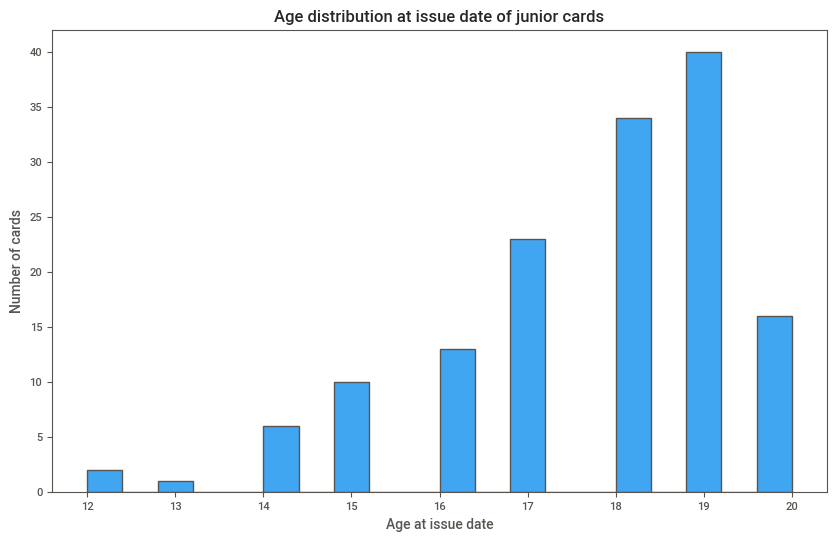

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

display(non_transactional_data)

# Filter rows where 'card_type' contains 'junior' (case insensitive)
junior_cards = non_transactional_data[
    non_transactional_data["type_card"].str.contains("junior", case=False, na=False)
]

display(junior_cards)

# Calculate age at issue
junior_cards["age_at_issue"] = (
    junior_cards["issued_card"] - junior_cards["birth_day_client"]
).dt.days // 365

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=junior_cards, x="age_at_issue", bins=20)
plt.title("Age distribution at issue date of junior cards")
plt.xlabel("Age at issue date")
plt.ylabel("Number of cards")
plt.show()

In the advertising campaign, we do not want to promote children's/junior cards (for whatever reasons). First, I looked at the distribution of age at issuance. Here I see that there are not many junior cards, nor are the cards issued at a late age.

In [102]:
num_accounts_before = len(non_transactional_data)
# Filter rows where 'card_type' does not contain 'junior' (case insensitive)
non_transactional_data = non_transactional_data[
    ~non_transactional_data["type_card"].str.contains("junior", case=False, na=False)
]
num_accounts_after = len(non_transactional_data)
num_junior_cards = num_accounts_before - num_accounts_after
print(f"Number of junior cards removed: {num_junior_cards}")

Number of junior cards removed: 145


In [103]:
%%capture
import subprocess
import pathlib


try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".py":
    # If it's a Python script, convert it to a notebook
    try:
        subprocess.check_output(["jupytext", "--to", "notebook", str(file_path)])
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        subprocess.check_output(["jupytext", "--to", "py:percent", str(file_path)])
        print("Converted to Python script.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")

In [104]:
# Update html output
# jupyter nbconvert --to html --template pj AML_MC.ipynb